# 👩‍🔬 Colab specific header

In [1]:
# MOUNT GDRIVE TO COLAB
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [2]:
if IN_COLAB:
  from IPython.display import JSON
  from google.colab import output
  from subprocess import getoutput
  import os
  
  def shell(command):
    if command.startswith('cd'):
      path = command.strip().split(maxsplit=1)[1]
      os.chdir(path)
      return JSON([''])
    return JSON([getoutput(command)])
  output.register_callback('shell', shell)

In [3]:
## UNCOMMENT BELOW TO RUN COLAB SHELL
# %%html
# <div id=term_demo></div>
# <script src="https://code.jquery.com/jquery-latest.js"></script>
# <script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
# <link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
# <script>
#   $('#term_demo').terminal(async function(command) {
#       if (command !== '') {
#           try {
#               let res = await google.colab.kernel.invokeFunction('shell', [command])
#               let out = res.data['application/json'][0]
#               this.echo(new String(out))
#           } catch(e) {
#               this.error(new String(e));
#           }
#       } else {
#           this.echo('');
#       }
#   }, {
#       greetings: 'Welcome to Colab Shell',
#       name: 'colab_demo',
#       height: 250,
#       prompt: 'colab > '
#   });

# 🏃‍♂️ For all Jupyter-like environments

In [4]:
# UNCOMENT REQUIREMENTS TO BE INSTALLED
# from IPython.display import clear_output
# !pip install -r requirements_colab.txt
# !pip install -r requirements.txt
# clear_output(wait=False)

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [6]:
# Jupyter is expected to be run from git repository root directory.
# By default CategoryLearning is the directory name. Modify path in case of an error.
# It's is recommended to use an absolute path in lib_path
import os
from pathlib import Path
lib_path = Path('../')
lib_path = lib_path.resolve()
print(f'Current absolute path to Git root directory: {lib_path}')
assert 'catlearn' in os.listdir(lib_path), 'It seems notebook is run not from the root directory. Modify lib_path.'

Current absolute path to Git root directory: /home/christophe/workspace/arreason/CategoryLearning


In [7]:
# Modify notebook environment path in case it was updated in the cell above
os.chdir(lib_path)

In [8]:
from typing import Callable, Iterable, Any, Union
import sys
import torch
import random
import numpy as np
import networkx as nx
from datetime import datetime
import collections
from tqdm import (trange, tqdm)
from matplotlib import pyplot as plt

from data.dataset import Dataset
from catlearn.utils.numerics import (Tsor, DEFAULT_EPSILON, one_hot)
from catlearn.graph_utils import (DirectedGraph,
                                    uniform_sample,
                                    random_walk_edge_sample,
                                    random_walk_vertex_sample,
                                    n_hop_sample,
                                    clean_selfloops,
                                    augment_graph,
                                    create_revers_rels)
from catlearn.algebra_models import (Algebra, VectAlgebra, VectMultAlgebra)
from catlearn.composition_graph import CompositeArrow
from catlearn.categorical_model import (TrainableDecisionCatModel, RelationModel,
                                        ScoringModel)

In [9]:
# > VS CODE SPECIFIC <
# Uncoment if run in VS Code embeded notebook
# import warnings
# Needed to show warnings in VS Code integrade jupyter
# warnings.simplefilter(action="default")

In [10]:
# Enable reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(42)
torch.manual_seed(42)

In [11]:
# CHECK GPU (ONLY ON MACHINES WITH NVIDIA GPU)
# !nvidia-smi
# print(torch.cuda.device(0))
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))
# print(torch.cuda.is_available())
# CHECK KERNEL PYTHON VERSION
# print(sys.version)

For weights and biases integration, run in terminal:  
```wandb login```
On request to enter API key, pasthe the key from website.  
Last valid key ```ca29a13bf2ac0110134723b00696d94b9a6ad032```  
Check that you are logged as ```arreason-labs```

In [12]:
from wandb_logger import save_params, save_file, wandb
from catlearn.utils.metrics import compute_training_metrics, compute_average_missing_source_target_kge_metrics

wandb: Currently logged in as: cculan (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### SET BELOW ```default_tensor = torch.cuda.FloatTensor``` FOR GPU


In [13]:
# Specify dataset path
# ds_path_wn18 = './Datasets/wn18rr/text'
ds_path_wn18 = lib_path/'Datasets/wn18rr/text'
# ds_path_fb15 = './Datasets/fb15k-237'

In [14]:
ds_wn18 = Dataset(path=ds_path_wn18, ds_name='wn18', node_vec_dim=10)

In [15]:
# MODIFY BELOW TO USE RIGHT DATASET
ds = ds_wn18

# Check dataset has multiconnections

In [16]:
# ds_wn18.load()
# ds_l = list(ds_wn18.train)
# ds_l_edges = [(tpl[0], tpl[1]) for tpl in ds_l]
# cnt_edges = collections.Counter(ds_l_edges)
# cnt_edges = sorted(cnt_edges.items(), key=lambda item: item[1], reverse=True)
# cnt_edges_multi = [tpl for tpl in cnt_edges if tpl[1] > 1]
# ds.train = ds_l
# print(f'Edges with 2 relations: {len(cnt_edges_multi)}')
# print(f'Max number of multirelations: {max([cnt for edge, cnt in cnt_edges_multi])}')

## Create training / validation graphs


In [17]:
graph_train = DirectedGraph(ds.train())

In [18]:
graph_valid = DirectedGraph(ds.valid())

## Clean graph

In [19]:
clean_selfloops(graph_train)


Following 7 selfloop edge(s) are found:
[(30440, 30440), (24410, 24410), (18188, 18188), (24568, 24568), (10143, 10143), (9618, 9618), (25511, 25511)]
7 selfloop edges are removed.
Following 0 isolate(s) are found:
[]
0 isolates are removed.


In [20]:
print(nx.info(graph_train))

Name: 
Type: DirectedGraph
Number of nodes: 40714
Number of edges: 86719
Average in degree:   2.1300
Average out degree:   2.1300


# Augment graph

In [21]:
relation_revers = {
    '_hypernym': None,
    '_derivationally_related_form': '_derivationally_related_form',
    '_member_meronym': None,
    '_has_part': None,
    '_synset_domain_topic_of': None,
    '_instance_hypernym' : None,
    '_also_see': '_also_see',
    '_verb_group': '_verb_group',
    '_member_of_domain_usage': None,
    '_member_of_domain_region': None,
    '_similar_to': '_similar_to',
}

In [22]:
relation_revers_full = {
    '_hypernym': '_hypernym_rev',
    '_derivationally_related_form': '_derivationally_related_form',
    '_member_meronym': '_member_meronym_rev',
    '_has_part': '_has_part_rev',
    '_synset_domain_topic_of': '_synset_domain_topic_of_rev',
    '_instance_hypernym' : '_instance_hypernym_rev',
    '_also_see': '_also_see',
    '_verb_group': '_verb_group',
    '_member_of_domain_usage': '_member_of_domain_usage_rev',
    '_member_of_domain_region': '_member_of_domain_region_rev',
    '_similar_to': '_similar_to',
}

In [23]:
relation_revers = relation_revers_full

In [24]:
# relation2id_augmented, relation_id2vec_augmented, revers_rels = create_revers_rels(relation_revers, ds.relation2id)
relation2id_augmented, relation_id2vec_augmented, revers_rels = create_revers_rels(relation_revers, ds.relation2id)

In [25]:
augment_graph(graph_train, revers_rels)

In [26]:
# if relation_revers_full is used, check there is a reverse edge for each edge
# edges_without_revers = [(u, v) for (u, v) in graph_train.edges(data=False) if not graph_train.has_edge(v, u)]
# assert edges_without_revers == []

# Print graphs stats

In [27]:
print(nx.info(graph_train))

Name: 
Type: DirectedGraph
Number of nodes: 40714
Number of edges: 143664
Average in degree:   3.5286
Average out degree:   3.5286


# Define Relation model

In [28]:
class CustomRelation(RelationModel):
    """ 
    """
    def __init__(self, nb_features: int, nb_labels: int, algebra: Algebra) -> None:
        self.linear = torch.nn.Linear(2 * nb_features + nb_labels, algebra.flatdim)

    def named_parameters(self, recurse: bool = True) -> Iterable[Tsor]:
        return self.linear.named_parameters(recurse=recurse)

    def __call__(self, x: Tsor, y: Tsor, l: Tsor) -> Tsor:
        """ Compute x R y """
        return self.linear(torch.cat((x, y, l), -1))

# Define Score model

In [29]:
class CustomScore(ScoringModel):
    """ Must be defined. depends on algebra and 
    in the scope of definition of the project. """
    def __init__(
            self,
            nb_features: int,
            nb_scores: int,
            algebra: Algebra) -> None:
        self.linear = torch.nn.Linear(
            2 * nb_features + algebra.flatdim, nb_scores + 1)
        self.softmax = torch.nn.Softmax(dim=-1)

    def named_parameters(self, recurse: bool = True) -> Iterable[Tsor]:
        return self.linear.named_parameters(recurse=recurse)

    def __call__(self, src: Tsor, dst: Tsor, rel: Tsor) -> Tsor:
        """ Compute S(src, dst, rel) """
        cat_input = torch.cat((src, dst, rel), -1)
        return self.softmax(self.linear(cat_input))[..., :-1]

# Create training models

In [30]:
algebra = VectMultAlgebra(ds.entity_vec_dim)

In [31]:
relation_model = CustomRelation(
    nb_features=ds.entity_vec_dim,
    nb_labels=len(relation2id_augmented),
    algebra=algebra
)

In [32]:
scoring_model = CustomScore(
    nb_features=ds.entity_vec_dim,
    nb_scores=len(relation2id_augmented),
    algebra=algebra
)

In [33]:
model = TrainableDecisionCatModel(
    relation_model=relation_model,
    label_universe=relation_id2vec_augmented,
    scoring_model=scoring_model,
    algebra_model=algebra,
    optimizer=torch.optim.Adam,
    epsilon=DEFAULT_EPSILON
)

In [34]:
# DEBUG NOTE: datatype comparaison
# Dataset interable format [src:int, tgt:int, lbl: {id:int: None}]
# CompositeArrow data format:  [[src: int, tgt: int], [label: int]]

# Create training loop

In [35]:
def graph_to_nodes_edges(graph: DirectedGraph):
    nodes = ((src, dst) for src, dst in graph.edges(data=False))
    edges = (list(rel.keys()) for _, _, rel in graph.edges(data=True))
    return nodes, edges

In [36]:
def nodes_edges_to_arrows(nodes, edges):
    return [CompositeArrow(nodes=node_pair, arrows=[edge]) for node_pair, edges in zip(nodes, edges) for edge in edges]

In [37]:
def plot_subgraphs(subgraph, batch_n, plot_nth=5, graph_info=True):
    """Plot each n'th subgraph for debug"""
    if not batch_n % plot_nth:
        nx.draw_networkx(subgraph)
        plt.show()
        if graph_info: print(nx.info(subgraph))

In [38]:
def init_run_dir():
    train_folder = lib_path/'log_runs'
    print(f'\nModels are saved in: {train_folder}', flush=True)
    if not os.path.isdir(train_folder):
        os.mkdir(train_folder)
    train_run_dir = train_folder/datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    os.mkdir(train_run_dir)
    return train_run_dir

In [39]:
def save_model(model: TrainableDecisionCatModel,
                epoch: int,
                run_path: Path,
                save_each_nth: int = None,
                specific_epochs: list = None,
                wandb_upload: bool = True) -> Union[None, Path]:
    """Saves model to a file. Optionaly logs to wandb."""
    if save_each_nth and specific_epochs:
        print('Either save_each_nth OR specific_epochs must be provided. Not both.')
        return None
    # epochs enumeration starts from 1 in logging
    epoch += 1
    if isinstance(save_each_nth, int) and epoch % save_each_nth:
        return None
    elif isinstance(specific_epochs, list) and not epoch in specific_epochs:
        return None
    model_path = run_path/f'model_epoch_{epoch}.pth'
    torch.save(dict(model.named_parameters()), model_path)
    if wandb_upload:
        save_file(model_path)
    return model_path

**Specification for sampler:**  
  
1. Control over number of nodes (time complexity).  
Must be fixed.  
Sampler must control number of nodes to be sampled to fullfill time complexity.  
Max number of edges for N nodes is:
- Directed graph: (N^2 - N) or N(N-1)
- Undirected graph: (N^2-N)/2
Computation complexity at training/inference (no composition) is:
(N^2 - N) -- compute relation for each pair of nodes

2. Control over number of edges:
Specified average (with tollerance).   
N_nodes/N_edges -- batch entropy / efficiency of learning.  
  
3. Control over degree of connectedness.
Specified min and N of mins.  
Min, max, average degree of connectedness -- batch entropy for links composition.  
  
4. Should not return not-connected nodes


In [40]:
def epoque_train(epoch: int, run_path: Path):
    batches = 2
    print_each_nth = 5
    for i in trange(batches, desc=f'Batch train'):
        # sampled_subgraph = uniform_sample(graph=graph_train, sample_vertices_size=20, rng=random.Random(),    with_edges=True)
        sampled_subgraph = random_walk_vertex_sample(graph=graph_train, rng=random.Random(), n_iter=10, n_seeds=1,  use_opposite=False)
        plot_subgraphs(sampled_subgraph, batch_n=i, plot_nth=1, graph_info=False)
        nodes, edges = graph_to_nodes_edges(sampled_subgraph)
        arrows = nodes_edges_to_arrows(nodes, edges)
        # NOTE: returned cache contains the same information each time
        cache, matches = model.train(
            data_points = ds.entity_id2vec,
            relations = arrows,
            # NOTE: Labels could be a couplete graph, a subgraph from random_walk or a sub-sub-graph used to create a batch
            labels = sampled_subgraph,
            step = True,
            match_negatives=False,
            max_arrow_number=2*len(sampled_subgraph),
        )
        wandb.log({**compute_training_metrics(cache, matches), 'epoque': 'train'})
        save_model(model, epoch=epoch, run_path=run_path, save_each_nth=3)

In [41]:
def epoque_valid():
    # for (5174 / n_iter) * 2 = ~320 batches (best case)
    batches = 1
    print_each_nth = 5
    range_with_progress = trange(batches)
    for i in trange(batches, desc='Batch valid'):
        sampled_subgraph = random_walk_vertex_sample(graph=graph_valid, rng=random.Random(), n_iter=10, n_seeds=1,  use_opposite=True)
        plot_subgraphs(sampled_subgraph, batch_n=i, plot_nth=print_each_nth, graph_info=False)
        nodes, edges = graph_to_nodes_edges(sampled_subgraph)
        arrows = nodes_edges_to_arrows(nodes, edges)
        cache, matches = model.train(
            data_points = ds.entity_id2vec,
            relations = arrows,
            # NOTE: Labels could be a complete graph, a subgraph from random_walk or a sub-sub-graph used to create a batch
            labels = sampled_subgraph,
            step = False,
            match_negatives=False,
            max_arrow_number=2*len(sampled_subgraph),
        )
        wandb.log({**compute_training_metrics(cache, matches), 'epoque': 'valid'})

In [42]:
from itertools import chain
import catlearn.utils
from catlearn.utils.metrics import compute_average_missing_source_target_kge_metrics

def compute_metrics(run_path: Path):
    # get the validation graph
    # note:!!! not at all how we should do it, but this
    # is for test purposes here
    # we should use the train graph, but it's too big to
    # test locally
    subgraph = graph_valid

    # add all relationships to and from 
    nodes, edges = graph_to_nodes_edges(subgraph)
    arrows = nodes_edges_to_arrows(nodes, edges)
    # NOTE: returned cache contains the same information each time
    cache = model.generate_cache(
        data_points = ds.entity_id2vec,
        relations = arrows,
        max_arrow_number=2*len(arrows),
    )
    # compute metrics
    # keep triplets whose source and target are included in subgraphs
    complete_triplets = list(chain(*(
        ((source, target, label) for label in labels)
        for (source, target, labels) in ds.valid())))
    metrics = compute_average_missing_source_target_kge_metrics(cache, complete_triplets, default_rank=len(subgraph) * len(model.label_universe), max_rank=3)
    return metrics



Models are saved in: /home/christophe/workspace/arreason/CategoryLearning/log_runs
Batch train:   0%|          | 0/2 [00:00<?, ?it/s]

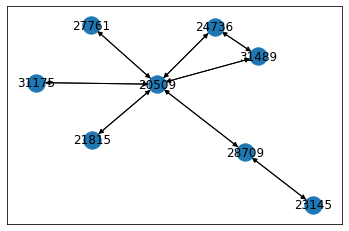


Batch train:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s]

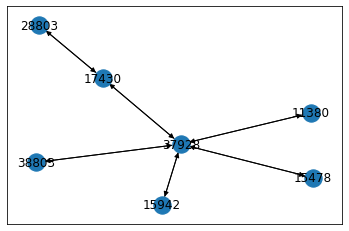


Batch train:   0%|          | 0/2 [00:00<?, ?it/s]

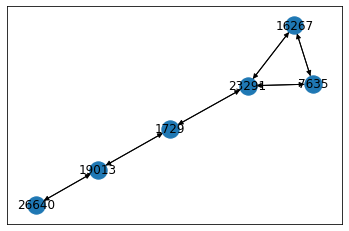


Batch train:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s]

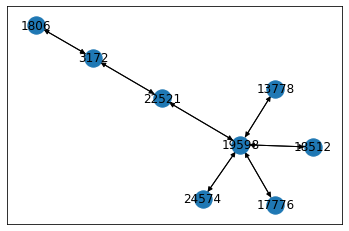


Batch train:   0%|          | 0/2 [00:00<?, ?it/s]

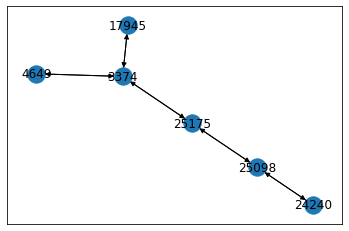

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")

Batch train:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s]

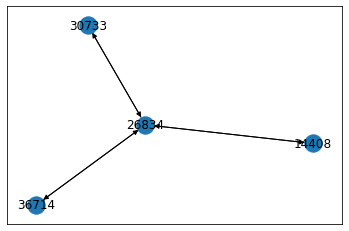

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")

Epoque: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


In [43]:
# NOTE: for large graphs, random_walk functions family can be used to sub-sample graph
# while preserving its topology 
epochs = 3
run_path = init_run_dir()
for j in trange(epochs, desc='Epoque'):
    epoque_train(epoch=j, run_path=run_path)
    # epoque_valid()


In [ ]:
metrics = compute_metrics(run_path=run_path)
print(metrics)
wandb.log(metrics)